In [1]:
%%capture
# Redirects the current working directory to the project directory
%cd ../src

In [2]:
%load_ext tensorboard

In [3]:
from model import RNNmodel

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [4]:
train = pd.read_csv('../raw/train.csv', parse_dates=['timestamp'])
test = pd.read_csv('../raw/test.csv', parse_dates=['timestamp'])

In [5]:
train

,timestamp,metric,submetric,value
0,2016-01-01,act.addr.cnt,active_addresses,3.167810e+05
1,2016-01-02,act.addr.cnt,active_addresses,4.179660e+05
2,2016-01-03,act.addr.cnt,active_addresses,3.984430e+05
3,2016-01-04,act.addr.cnt,active_addresses,4.131590e+05
4,2016-01-05,act.addr.cnt,active_addresses,4.352910e+05
...,...,...,...,...
111442,2020-12-27,txn.vol,transaction_volume_usd,1.404424e+10
111443,2020-12-28,txn.vol,transaction_volume_usd,1.915253e+10
111444,2020-12-29,txn.vol,transaction_volume_usd,1.927709e+10
111445,2020-12-30,txn.vol,transaction_volume_usd,2.131078e+10


In [6]:
test

,timestamp,metric,submetric,value
0,2021-01-01,act.addr.cnt,active_addresses,1.001890e+06
1,2021-01-02,act.addr.cnt,active_addresses,1.140633e+06
2,2021-01-03,act.addr.cnt,active_addresses,1.184688e+06
3,2021-01-04,act.addr.cnt,active_addresses,1.270082e+06
4,2021-01-05,act.addr.cnt,active_addresses,1.230529e+06
...,...,...,...,...
11036,2021-06-26,txn.vol,transaction_volume_usd,2.566747e+10
11037,2021-06-27,txn.vol,transaction_volume_usd,1.420066e+10
11038,2021-06-28,txn.vol,transaction_volume_usd,1.598501e+10
11039,2021-06-29,txn.vol,transaction_volume_usd,2.084147e+10


In [7]:
RNNmodel_main = RNNmodel(t=28, k=21, H=7, model_name='v1.7.13-main')
RNNmodel_k15 = RNNmodel(t=28, k=15, H=7, model_name='v1.7.13-k15')
RNNmodel_k10 = RNNmodel(t=28, k=10, H=7, model_name='v1.7.13-k10')

In [8]:
RNNmodel_main.initialize(train, test)
RNNmodel_k15.initialize(train, test)
RNNmodel_k10.initialize(train, test)

In [9]:
RNNmodel_main.train(batch_size=32, epochs=150)

In [10]:
RNNmodel_main.RNNmodel.summary()

Model: "v1.7.13-main"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Past_Inputs (InputLayer)    [(None, 28, 21)]          0         
                                                                 
 Normalizer (Normalization)  multiple                  43        
                                                                 
 Encoder (LSTM)              multiple                  73500     
                                                                 
 Future_Inputs (InputLayer)  [(None, 28, 5)]           0         
                                                                 
 Decoder (LSTM)              multiple                  65500     
                                                                 
 time_distributed (TimeDistr  multiple                 126       
 ibuted)                                                         
                                                      

In [11]:
RNNmodel_k15.train(batch_size=32, epochs=150)


In [12]:
RNNmodel_k15.RNNmodel.summary()

Model: "v1.7.13-k15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Past_Inputs (InputLayer)    [(None, 28, 15)]          0         
                                                                 
 Normalizer (Normalization)  multiple                  43        
                                                                 
 Encoder (LSTM)              multiple                  73500     
                                                                 
 Future_Inputs (InputLayer)  [(None, 28, 5)]           0         
                                                                 
 Decoder (LSTM)              multiple                  65500     
                                                                 
 time_distributed_1 (TimeDis  multiple                 126       
 tributed)                                                       
                                                       

In [13]:
RNNmodel_k10.train(batch_size=32, epochs=150)

In [14]:
RNNmodel_k10.RNNmodel.summary()

Model: "v1.7.13-k10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Past_Inputs (InputLayer)    [(None, 28, 10)]          0         
                                                                 
 Normalizer (Normalization)  multiple                  43        
                                                                 
 Encoder (LSTM)              multiple                  73500     
                                                                 
 Future_Inputs (InputLayer)  [(None, 28, 5)]           0         
                                                                 
 Decoder (LSTM)              multiple                  65500     
                                                                 
 time_distributed_2 (TimeDis  multiple                 126       
 tributed)                                                       
                                                       

### Test Predictions

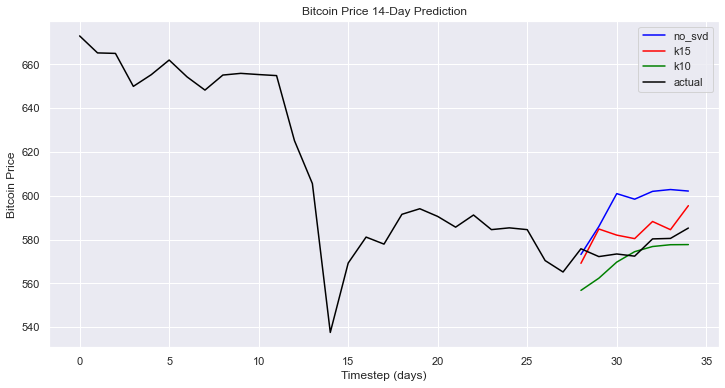

In [15]:
test_point=200
fig, ax = plt.subplots(figsize=(12,6))

xpoints_base = np.arange(RNNmodel_main.t + RNNmodel_main.H)
xpoints_pred = np.arange(RNNmodel_main.t, RNNmodel_main.t + RNNmodel_main.H)
ypoints_base = np.concatenate(
    (RNNmodel_main.trainplotdata[test_point], RNNmodel_main.ytrain[test_point])
)
ypoints_base = ypoints_base.reshape(ypoints_base.shape[0])

testpoints = RNNmodel_main.predict(RNNmodel_main.xtrain)
testpoints_k15 = RNNmodel_k15.predict(RNNmodel_k15.xtrain)
testpoints_k10 = RNNmodel_k10.predict(RNNmodel_k10.xtrain)



ax.plot(xpoints_pred, testpoints[test_point],
        linestyle='-', color='blue', label='no_svd')
ax.plot(xpoints_pred, testpoints_k15[test_point],
        linestyle='-', color='red', label='k15')
ax.plot(xpoints_pred, testpoints_k10[test_point],
        linestyle='-', color='green', label='k10')
ax.plot(xpoints_base, ypoints_base, color='black', label='actual')

ax.set_xlabel('Timestep (days)')
ax.set_ylabel('Bitcoin Price')
ax.set_title('Bitcoin Price 14-Day Prediction')
ax.legend()

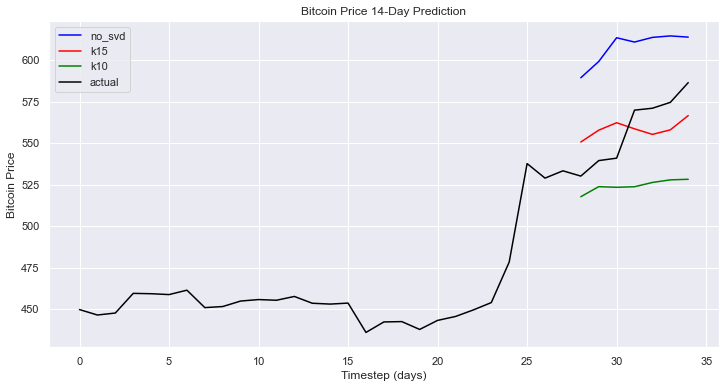

In [16]:
test_point=200
fig, ax = plt.subplots(figsize=(12,6))

xpoints_base = np.arange(RNNmodel_main.t + RNNmodel_main.H)
xpoints_pred = np.arange(RNNmodel_main.t, RNNmodel_main.t + RNNmodel_main.H)
ypoints_base = np.concatenate(
    (RNNmodel_main.trainplotdata[test_point], RNNmodel_main.ytrain[test_point])
)
ypoints_base = ypoints_base.reshape(ypoints_base.shape[0])

testpoints = RNNmodel_main.predict(RNNmodel_main.xtrain)
testpoints_k15 = RNNmodel_k15.predict(RNNmodel_k15.xtrain)
testpoints_k10 = RNNmodel_k10.predict(RNNmodel_k10.xtrain)



ax.plot(xpoints_pred, testpoints[test_point],
        linestyle='-', color='blue', label='no_svd')
ax.plot(xpoints_pred, testpoints_k15[test_point],
        linestyle='-', color='red', label='k15')
ax.plot(xpoints_pred, testpoints_k10[test_point],
        linestyle='-', color='green', label='k10')
ax.plot(xpoints_base, ypoints_base, color='black', label='actual')

ax.set_xlabel('Timestep (days)')
ax.set_ylabel('Bitcoin Price')
ax.set_title('Bitcoin Price 14-Day Prediction')
ax.legend()

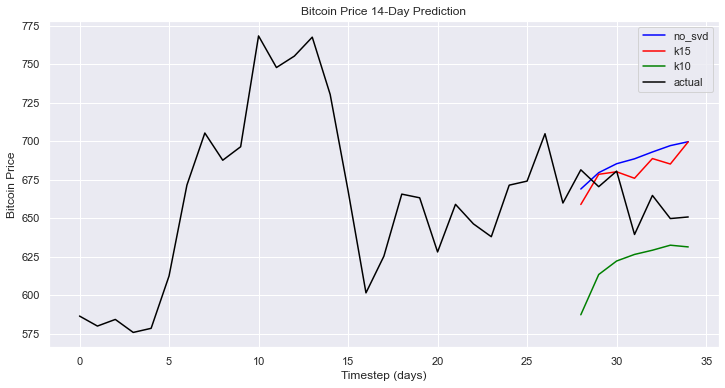

In [17]:
test_point=157
fig, ax = plt.subplots(figsize=(12,6))

xpoints_base = np.arange(RNNmodel_main.t + RNNmodel_main.H)
xpoints_pred = np.arange(RNNmodel_main.t, RNNmodel_main.t + RNNmodel_main.H)
ypoints_base = np.concatenate(
    (RNNmodel_main.trainplotdata[test_point], RNNmodel_main.ytrain[test_point])
)
ypoints_base = ypoints_base.reshape(ypoints_base.shape[0])

testpoints = RNNmodel_main.predict(RNNmodel_main.xtrain)
testpoints_k15 = RNNmodel_k15.predict(RNNmodel_k15.xtrain)
testpoints_k10 = RNNmodel_k10.predict(RNNmodel_k10.xtrain)



ax.plot(xpoints_pred, testpoints[test_point],
        linestyle='-', color='blue', label='no_svd')
ax.plot(xpoints_pred, testpoints_k15[test_point],
        linestyle='-', color='red', label='k15')
ax.plot(xpoints_pred, testpoints_k10[test_point],
        linestyle='-', color='green', label='k10')
ax.plot(xpoints_base, ypoints_base, color='black', label='actual')

ax.set_xlabel('Timestep (days)')
ax.set_ylabel('Bitcoin Price')
ax.set_title('Bitcoin Price 14-Day Prediction')
ax.legend()

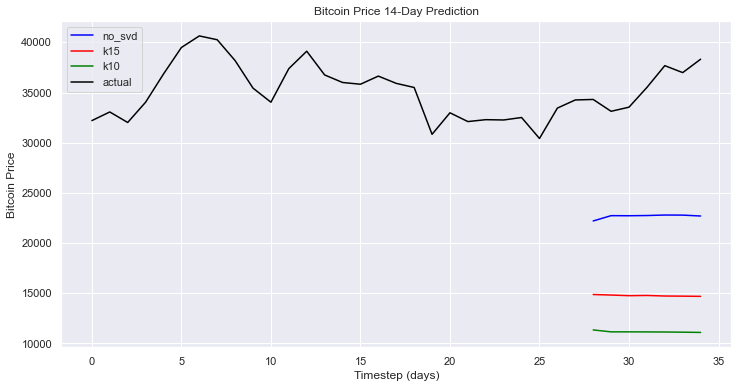

In [27]:
test_point=1
fig, ax = plt.subplots(figsize=(12,6))

xpoints_base = np.arange(RNNmodel_main.t + RNNmodel_main.H)
xpoints_pred = np.arange(RNNmodel_main.t, RNNmodel_main.t + RNNmodel_main.H)
ypoints_base = np.concatenate(
    (RNNmodel_main.testplotdata[test_point], RNNmodel_main.ytest[test_point])
)
ypoints_base = ypoints_base.reshape(ypoints_base.shape[0])

testpoints = RNNmodel_main.predict(RNNmodel_main.xtest)
testpoints_k15 = RNNmodel_k15.predict(RNNmodel_k15.xtest)
testpoints_k10 = RNNmodel_k10.predict(RNNmodel_k10.xtest)



ax.plot(xpoints_pred, testpoints[test_point],
        linestyle='-', color='blue', label='no_svd')
ax.plot(xpoints_pred, testpoints_k15[test_point],
        linestyle='-', color='red', label='k15')
ax.plot(xpoints_pred, testpoints_k10[test_point],
        linestyle='-', color='green', label='k10')
ax.plot(xpoints_base, ypoints_base, color='black', label='actual')

ax.set_xlabel('Timestep (days)')
ax.set_ylabel('Bitcoin Price')
ax.set_title('Bitcoin Price 14-Day Prediction')
ax.legend()

### Model Evaluation

In [19]:
RNNmodel_main.evaluate()

5/5 [==============================] - 0s 7ms/step - loss: 768932032.0000 - rmse: 27729.6230


In [20]:
RNNmodel_k15.evaluate()

5/5 [==============================] - 0s 9ms/step - loss: 852528192.0000 - rmse: 29198.0840


In [21]:
RNNmodel_k10.evaluate()

5/5 [==============================] - 0s 8ms/step - loss: 1370589056.0000 - rmse: 37021.4688


### Model Weights Saving

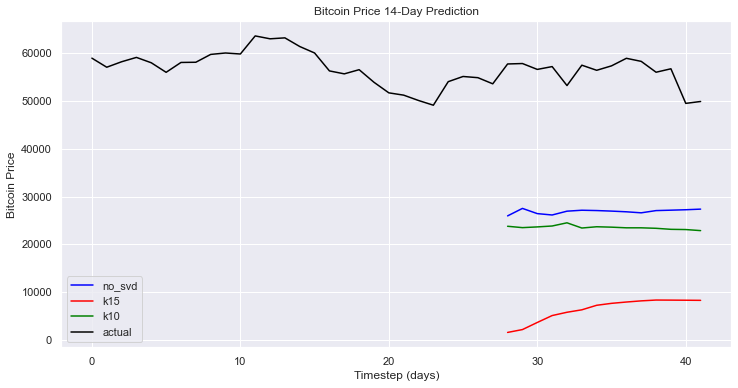

In [32]:
RNNmodel_main.RNNmodel.save_weights('../logs/weights/' + RNNmodel_main.model_name)
RNNmodel_k15.RNNmodel.save_weights('../logs/weights/' + RNNmodel_k15.model_name)
RNNmodel_k10.RNNmodel.save_weights('../logs/weights/' + RNNmodel_k10.model_name)